# Generation of hyperspectral samples using Wasserstein-GANs

Wasserstein-GANs are Generative Adversarial Models that can be used to generate synthetic data that approximates a specific input distribution of real data.

In this notebook, we show how to use such a tool to generate *ex nihilo* synthetic hyperspectral samples.

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
torch.cuda.is_available()

True

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.utils.data
from scipy.io import loadmat
from skimage import io
from PIL import Image


We load the Pavia University dataset. The `.mat` files are available on [this website](http://www.ehu.eus/ccwintco/index.php?title=Hyperspectral_Remote_Sensing_Scenes).

In [3]:
img = loadmat('./PaviaU.mat')['paviaU']
gt = loadmat('./PaviaU_gt.mat')['paviaU_gt']
mask = np.random.randint(0, 100, gt.shape) < 5
train_gt = np.copy(gt)
train_gt[np.nonzero(~mask)] = 0
test_gt = np.copy(gt)
test_gt[train_gt > 0] = 0
rgb = img[:,:,(55,41,12)]
rgb = (255 * (rgb.astype(np.float32) - rgb.min())/(rgb.max() - rgb.min())).astype(np.uint8)
print(np.shape(img))
print(np.shape(gt))
print(np.shape(train_gt))
print(np.shape(rgb))

(610, 340, 103)
(610, 340)
(610, 340)
(610, 340, 3)


In [4]:
# print(img[0][0])
# print(img[img > 1])
# counts = np.asarray(np.unique(gt,return_counts=True))
# print(counts)

In [5]:

# gt =  np.rot90(gt,1,(0,1))

# classes = np.array([
#     [153 ,  0 ,  0], #unspecified
#     [  0 ,  0 ,255], #roads
#     [  0, 255 ,  0], #vegetation
#     [  0 ,255 ,255], #water
#     [255 ,  0 ,0],#buidings 
#     [255 ,127 , 80]#cars
# ])
# # d = {
# #     repr([153 ,  0 ,  0]): 0,
# #     repr([0 ,  0 ,255]): 1,
# #     repr([ 0, 255 ,  0]): 2,
# #     repr([ 0 ,255 ,255]): 3,
# #     repr([255 ,  0 ,0]): 4,
# #     repr([255 ,127 , 80]): 5,
# # }
# gt_temp = np.zeros((gt.shape[0],gt.shape[1]))

# for i in range(gt.shape[0]):
#     for j in range(gt.shape[1]):
#         val = gt[i][j]
#         for id in range(len(classes)):
#             if np.array_equal(val, classes[id]):
#                 gt_temp[i][j] = id
        
        
# gt = gt_temp        
# gt_new = Image.fromarray(gt)
# gt_new.save('gt_new.tif')

In [6]:
# ae_img = io.imread('C:\\Users\\golde\\Documents\\GitHub\\AeroRIT\\Aerial Data\\Collection\\image_hsi_radiance.tif')
# ae_img = np.rot90(ae_img,1,(0,2))
# pavia_img = loadmat('./PaviaU.mat')['paviaU']

In [7]:
# print(ae_img[233][354])
# print(pavia_img[233][235])
# _counts = np.asarray(np.unique(ae_img,return_counts=True))
# print(len(_counts[0]),_counts.T)
# _counts = np.asarray(np.unique(pavia_img,return_counts=True))
# print(len(_counts[0]),_counts.T)

In [8]:
# img = io.imread('C:\\Users\\golde\\Documents\\GitHub\\AeroRIT\\Aerial Data\\Collection\\image_hsi_radiance.tif')
# img_rgb = io.imread('C:\\Users\\golde\\Documents\\GitHub\\AeroRIT\\Aerial Data\\Collection\\image_rgb.tif')
# # img = io.imread('E:\\Accessories\\Documents\\Python Scripts\\AeroRIT\\Aerial Data\\Collection\\image_hsi_radiance.tif')
# # img_rgb = io.imread('E:\\Accessories\\Documents\\Python Scripts\\AeroRIT\\Aerial Data\\Collection\\image_rgb.tif')
# # E:\Accessories\Documents\Python Scripts\AeroRIT\Aerial Data
# # gt = io.imread('C:\\Users\\golde\\Documents\\GitHub\\AeroRIT\\Aerial Data\\Collection\\image_labels.tif')
# gt = io.imread('./gt_new.tif')
# gt = gt.astype(int)

# img = np.rot90(img,1,(0,2))
# img_rgb =  np.rot90(img_rgb,1,(0,1))

# # crop images
# crop_offset = 348
# crop_w = 610*2 + crop_offset
# crop_h = 340*2 + crop_offset

# img = img[crop_offset:crop_w,crop_offset:crop_h,:]
# img_rgb = img_rgb[crop_offset:crop_w,crop_offset:crop_h,:]
# gt = gt[crop_offset:crop_w,crop_offset:crop_h]
# img = img[:3974,:1972,:]
# img_rgb = img_rgb[:3974,:1972,:]
# gt = gt[:3974,:1972]
# counts = np.asarray(np.unique(gt,return_counts=True))
# print(counts)
# print(np.shape(img))
# print(np.shape(img_rgb))
# print(gt.shape)

# mask = np.random.randint(0, 100, gt.shape) < 5
# train_gt = np.copy(gt)
# train_gt[np.nonzero(~mask)] = 0
# test_gt = np.copy(gt)
# test_gt[train_gt > 0] = 0
# rgb = img_rgb
# rgb = (255 * (rgb.astype(np.float32) - rgb.min())/(rgb.max() - rgb.min())).astype(np.uint8)
# print(np.shape(img))
# print(np.shape(gt))
# print(np.shape(train_gt))
# print(np.shape(rgb))




The ground truth is shown below. We sample 10% from the pixels as training samples.

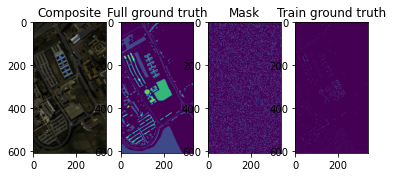

In [9]:
fig = plt.figure()
fig.add_subplot(141)
plt.imshow(rgb)
plt.title("Composite")
fig.add_subplot(142)
plt.imshow(gt)
plt.title("Full ground truth")
fig.add_subplot(143)
plt.imshow(mask)

plt.title("Mask")
fig.add_subplot(144)
plt.imshow(train_gt)
plt.title("Train ground truth")
plt.show()

We define a `HyperX` class to hold the dataset. Note that the label is encoded as a one-hot vector.

In [10]:
from skimage import morphology

class HyperX(torch.utils.data.Dataset):
    
    def __init__(self, data, ground_truth, semi=False):
        super(HyperX, self).__init__()
        # print('init dataloader')
        # Normalize the data in [0,1]
        data = (data - data.min()) / (data.max() - data.min())
        self.data = data
        self.gt = ground_truth
        self.n_classes = len(np.unique(ground_truth))
        if semi:
            # Semi-supervision, include neighbours at 50px
            x_pos, y_pos = np.nonzero(morphology.dilation(ground_truth > 0, morphology.disk(50)))
        else:
            x_pos, y_pos = np.nonzero(ground_truth)
        self.indices = [idx for idx in zip(x_pos, y_pos)]
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, i):
        x, y = self.indices[i]
        data = self.data[x,y]
        # Get the label in one-hot encoded style
        # print(self.n_classes,x, y,np.eye(self.n_classes),self.gt[x, y])
        label = np.asarray(np.eye(self.n_classes)[self.gt[x, y]], dtype='int64')
        return torch.from_numpy(data), torch.from_numpy(label)

In [11]:
import os
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# Basic generator that maps: noise + condition -> fake samples
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # LeakyReLU is preferred to keep gradients flowing even for negative activations
        self.generator = torch.nn.Sequential(
            torch.nn.Linear(z_dim + c_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, X_dim),
            torch.nn.Sigmoid() # smooth [0,1] outputs
        )
        self.apply(weight_init)

    def forward(self, z, c):
        # Concatenate the noise and condition
        inputs = torch.cat([z, c], 1)
        return self.generator(inputs)

# Basic fully connected discriminator: sample -> -infty -- fake - 0 - real -- +infty
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = torch.nn.Sequential(
            torch.nn.Linear(X_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, 1)
        )
        
        self.apply(weight_init)

    def forward(self, X):
        return self.discriminator(X)

# Basic fully connected classifier: sample -> class
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.discriminator = torch.nn.Sequential(
            torch.nn.Linear(X_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, c_dim)
        )
        
        self.apply(weight_init)

    def forward(self, X):
        return self.discriminator(X)

In [12]:
mb_size = 256 # Batch size
z_dim = 30   # Noise dimension
X_dim = img.shape[-1] # Number of bands
print(X_dim)
h_dim = 512  # Hidden layer size
d_step = 5   # Number of discriminator training steps for ea ch generator training step
lr = 5e-5    # Learning rate
c_weight = 0.2 # Auxiliary classifier weight
flip_percentage = 0.0 # Proportion of label flipping
mixup_alpha = 0.1 # Mixup
semi_supervised = True # semi-supervision (set to True to include unlabeled samples)

# Build the dataset and data loader
data_loader = torch.utils.data.DataLoader(
    HyperX(img, train_gt if semi_supervised else gt), batch_size=mb_size, shuffle=True)
# c_dim = condition vector size
c_dim = data_loader.dataset.n_classes
print(c_dim)
# Ignore the class 0
class_weights = torch.ones((c_dim))
class_weights[0] = 0.
class_weights = class_weights.cuda()

103
10


In [13]:
# Initialize weights using the He et al. (2015) policy.
def weight_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d, nn.Conv3d, nn.ConvTranspose3d)):
        torch.nn.init.kaiming_normal_(m.weight.data)

# Spherical interpolation between two vectors on the unit hypersphere
# See : https://github.com/soumith/dcgan.torch/issues/14
def slerp(val, low, high):
    omega = np.arccos(np.clip(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)), -1, 1))
    so = np.sin(omega)
    if so == 0:
        return (1.0-val) * low + val * high # L'Hopital's rule/LERP
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega) / so * high

def lerp(val, low, high):
    return (1.0-val) * low + val * high # L'Hopital's rule/LERP

# Gradient penalty from the Improved WGAN training
# From : https://github.com/EmilienDupont/wgan-gp
# Use penalty_weight set at 10, as suggested in the paper
def calc_gradient_penalty(netD, real_data, generated_data, penalty_weight=10):
        batch_size = real_data.size()[0]

        alpha = torch.rand(batch_size, 1) if real_data.dim() == 2 else torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(real_data)
        alpha = alpha.cuda()
        
        interpolated = alpha * real_data + (1 - alpha) * generated_data
        #interpolated = Variable(interpolated, requires_grad=True)
        interpolated.requires_grad_()
        interpolated = interpolated.cuda()

        # Calculate probability of interpolated examples
        prob_interpolated = netD(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda(),
                               create_graph=True, retain_graph=True)[0]

        # Gradients have shape (batch_size, num_channels, img_width, img_height),
        # so flatten to easily take norm per example in batch
        gradients = gradients.view(batch_size, -1)

        # Derivatives of the gradient close to 0 can cause problems because of
        # the square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return penalty_weight * ((gradients_norm - 1) ** 2).mean()
    
def reset_grad(*nets):
    for net in nets:
        net.zero_grad()
        
def plot_mean_std(samples):
    mean_spectrum = np.mean(samples, axis=0)
    std_spectrum = np.std(samples, axis=0)
    plt.plot(mean_spectrum - std_spectrum, linestyle='dotted', label='-std')
    plt.plot(mean_spectrum, label='mean')
    plt.plot(mean_spectrum + std_spectrum, linestyle='dotted', label='+std')

  0%|                                                                                       | 0/100000 [00:00<?, ?it/s]C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iter-0; D_loss: -1.6258080005645752; G_loss: 2.7550666332244873; C_loss: 1.9482144117355347


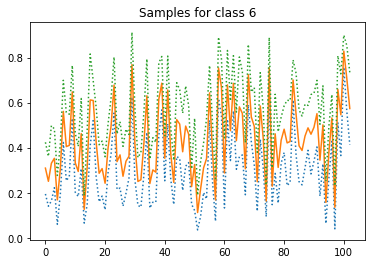

  1%|▋                                                                          | 999/100000 [01:34<2:25:46, 11.32it/s]

Iter-1000; D_loss: -0.22723504900932312; G_loss: -0.10017222166061401; C_loss: 0.20496782660484314


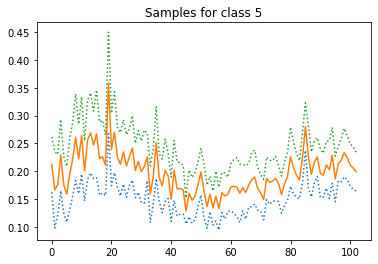

  2%|█▍                                                                        | 2000/100000 [03:03<2:25:05, 11.26it/s]

Iter-2000; D_loss: -0.1445373296737671; G_loss: 0.005069374106824398; C_loss: 0.07566998898983002


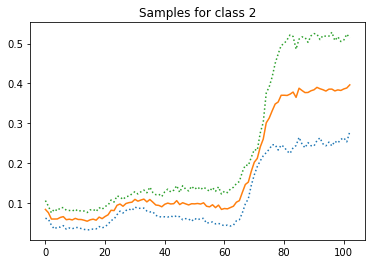

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  3%|██▏                                                                       | 3000/100000 [04:34<2:35:48, 10.38it/s]

Iter-3000; D_loss: -0.06752467155456543; G_loss: 0.0019539156928658485; C_loss: 0.03109486773610115


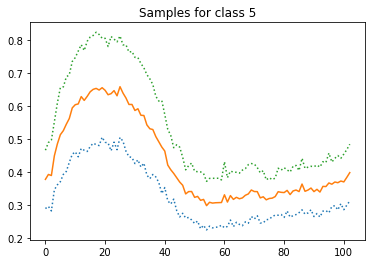

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  4%|██▉                                                                       | 4000/100000 [06:06<2:23:40, 11.14it/s]

Iter-4000; D_loss: -0.05168456956744194; G_loss: 0.010600549168884754; C_loss: 0.027161404490470886


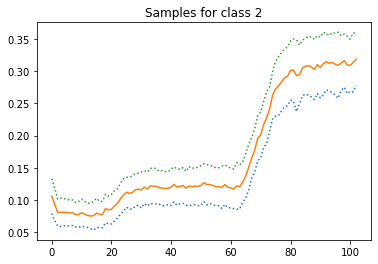

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  5%|███▋                                                                      | 5000/100000 [07:36<2:19:38, 11.34it/s]

Iter-5000; D_loss: -0.019852759316563606; G_loss: 0.06877617537975311; C_loss: 0.03652695193886757


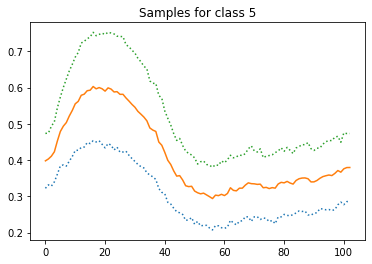

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  6%|████▍                                                                     | 6000/100000 [09:05<2:19:52, 11.20it/s]

Iter-6000; D_loss: -0.03647070378065109; G_loss: 0.07961145043373108; C_loss: 0.02914721891283989


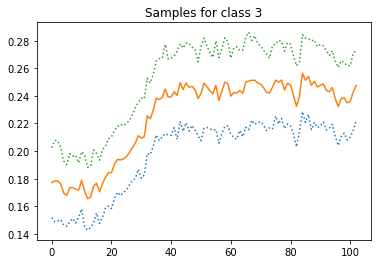

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  7%|█████▏                                                                    | 7000/100000 [10:37<2:16:01, 11.39it/s]

Iter-7000; D_loss: -0.028725143522024155; G_loss: 0.08500244468450546; C_loss: 0.019707903265953064


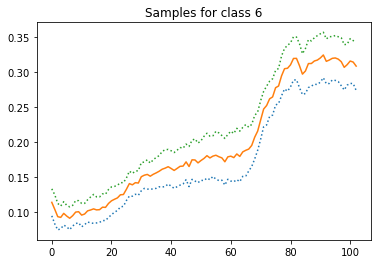

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  8%|█████▉                                                                    | 7999/100000 [12:05<2:13:56, 11.45it/s]

Iter-8000; D_loss: -0.029011022299528122; G_loss: 0.07831133902072906; C_loss: 0.02091144770383835


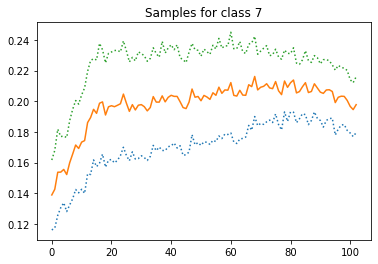

  9%|██████▋                                                                   | 8999/100000 [13:34<2:12:17, 11.46it/s]

Iter-9000; D_loss: -0.039760373532772064; G_loss: 0.048753730952739716; C_loss: 0.016178974881768227


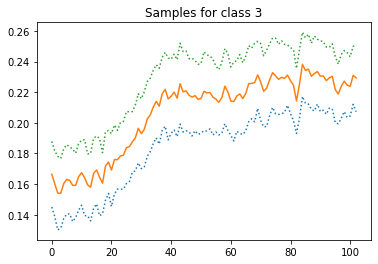

 10%|███████▎                                                                 | 10000/100000 [15:04<2:17:33, 10.91it/s]

Iter-10000; D_loss: -0.024791594594717026; G_loss: 0.07817908376455307; C_loss: 0.013914319686591625


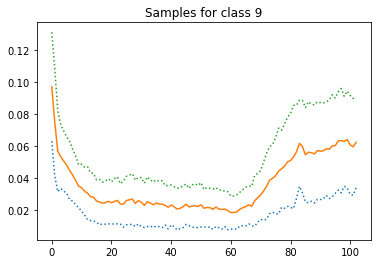

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 11%|████████                                                                 | 11000/100000 [16:38<2:14:50, 11.00it/s]

Iter-11000; D_loss: -0.03505537658929825; G_loss: 0.05131484940648079; C_loss: 0.014947192743420601


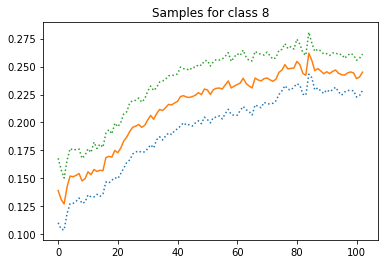

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 12%|████████▊                                                                | 12000/100000 [18:09<2:11:02, 11.19it/s]

Iter-12000; D_loss: -0.015288218855857849; G_loss: 0.019682209938764572; C_loss: 0.011794451624155045


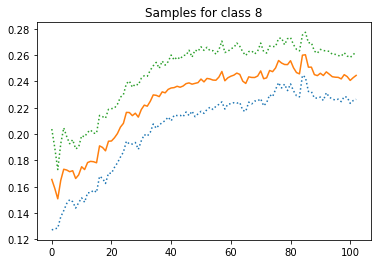

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 13%|█████████▍                                                               | 12999/100000 [19:40<2:10:43, 11.09it/s]

Iter-13000; D_loss: -0.0112173892557621; G_loss: 0.05751675367355347; C_loss: 0.24320463836193085


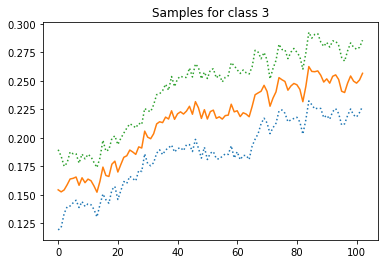

 14%|██████████▏                                                              | 14000/100000 [21:12<2:11:09, 10.93it/s]

Iter-14000; D_loss: -0.015665099024772644; G_loss: -0.011665860190987587; C_loss: 0.01329687237739563


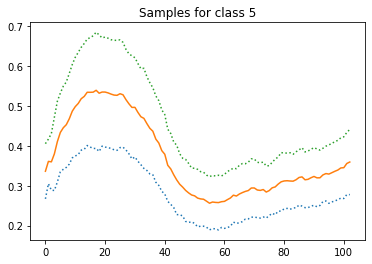

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 15%|██████████▉                                                              | 15000/100000 [22:43<2:08:26, 11.03it/s]

Iter-15000; D_loss: -0.018462635576725006; G_loss: -0.017809316515922546; C_loss: 0.010954477824270725


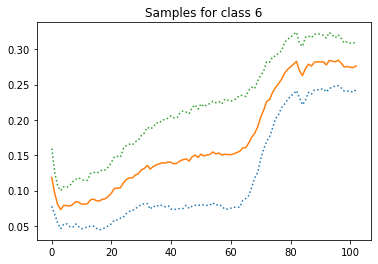

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 16%|███████████▋                                                             | 16000/100000 [24:15<2:07:43, 10.96it/s]

Iter-16000; D_loss: -0.01070115715265274; G_loss: -0.047714997082948685; C_loss: 0.0193632822483778


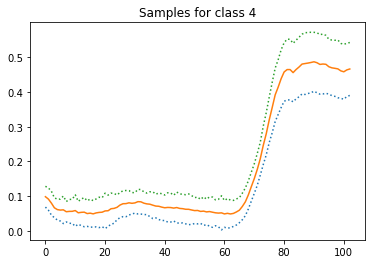

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 17%|████████████▍                                                            | 17000/100000 [25:46<2:04:54, 11.07it/s]

Iter-17000; D_loss: -0.010660259053111076; G_loss: -0.0676427111029625; C_loss: 0.021796531975269318


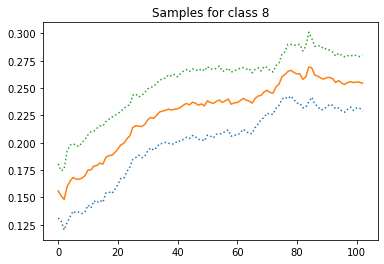

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 18%|█████████████▏                                                           | 17999/100000 [27:17<2:04:56, 10.94it/s]

Iter-18000; D_loss: -0.009345539845526218; G_loss: -0.0901741087436676; C_loss: 0.01544553879648447


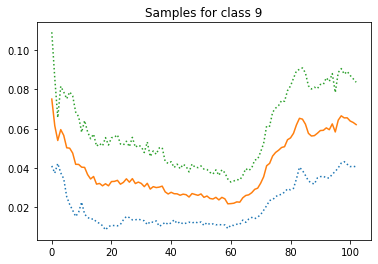

 19%|█████████████▊                                                           | 19000/100000 [28:49<2:00:34, 11.20it/s]

Iter-19000; D_loss: -0.019056517630815506; G_loss: -0.09132738411426544; C_loss: 0.01869131065905094


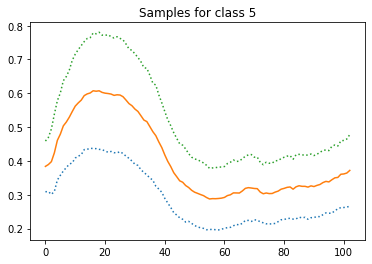

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 20%|██████████████▌                                                          | 20000/100000 [30:20<1:58:37, 11.24it/s]

Iter-20000; D_loss: -0.012429418042302132; G_loss: -0.11167392134666443; C_loss: 0.011604411527514458


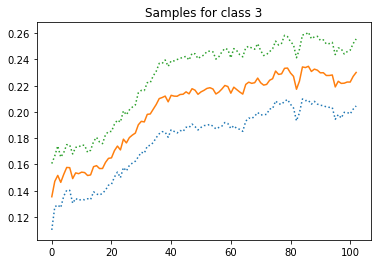

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 21%|███████████████▎                                                         | 21000/100000 [31:51<1:59:01, 11.06it/s]

Iter-21000; D_loss: -0.008569478057324886; G_loss: -0.12728530168533325; C_loss: 0.016718413680791855


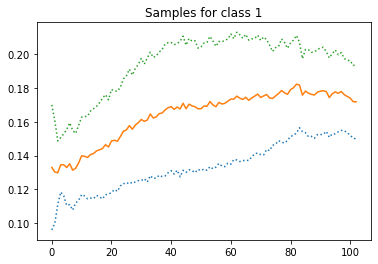

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 22%|████████████████                                                         | 22000/100000 [33:22<1:55:26, 11.26it/s]

Iter-22000; D_loss: -0.0057619912549853325; G_loss: -0.131572887301445; C_loss: 0.017980748787522316


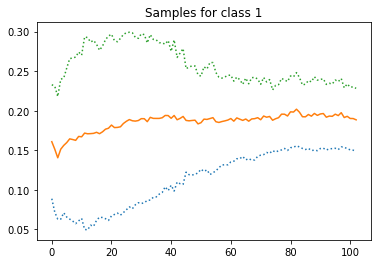

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 23%|████████████████▊                                                        | 22999/100000 [34:53<1:54:53, 11.17it/s]

Iter-23000; D_loss: -0.014986746944487095; G_loss: -0.12641571462154388; C_loss: 0.013050380162894726


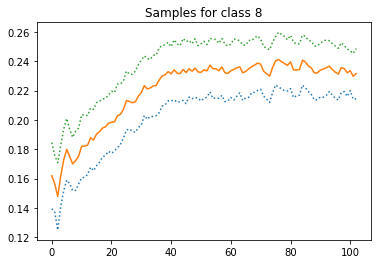

 24%|█████████████████▌                                                       | 24000/100000 [36:25<1:52:37, 11.25it/s]

Iter-24000; D_loss: -0.018168659880757332; G_loss: -0.13858510553836823; C_loss: 0.014235366135835648


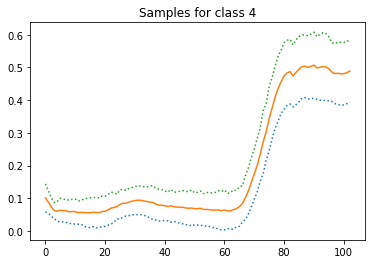

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 25%|██████████████████▎                                                      | 25000/100000 [37:56<1:51:25, 11.22it/s]

Iter-25000; D_loss: -0.010856173932552338; G_loss: -0.13963666558265686; C_loss: 0.01167997345328331


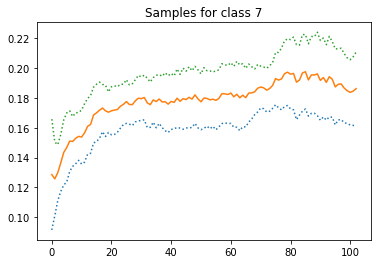

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 26%|██████████████████▉                                                      | 25999/100000 [39:27<1:52:45, 10.94it/s]

Iter-26000; D_loss: -0.00901571474969387; G_loss: -0.13740050792694092; C_loss: 0.07910085469484329


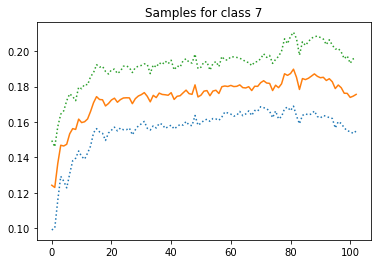

 27%|███████████████████▋                                                     | 26999/100000 [40:59<1:49:01, 11.16it/s]

Iter-27000; D_loss: -0.011792689561843872; G_loss: -0.16501149535179138; C_loss: 0.007829739712178707


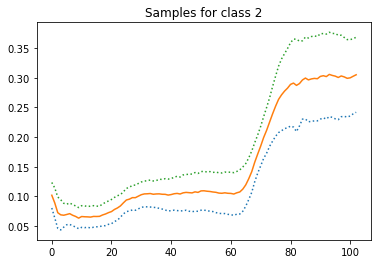

 28%|████████████████████▍                                                    | 28000/100000 [42:30<1:49:15, 10.98it/s]

Iter-28000; D_loss: -0.012386228889226913; G_loss: -0.16256049275398254; C_loss: 0.013548200018703938


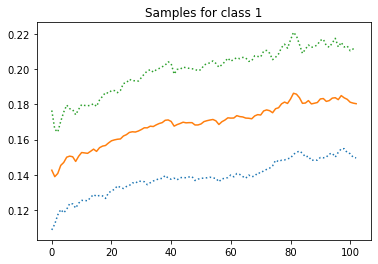

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 29%|█████████████████████▏                                                   | 28999/100000 [44:01<1:47:09, 11.04it/s]

Iter-29000; D_loss: -0.005570434499531984; G_loss: -0.1620318591594696; C_loss: 0.015252078883349895


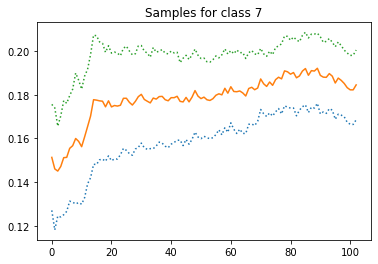

 30%|█████████████████████▉                                                   | 30000/100000 [45:33<1:47:38, 10.84it/s]

Iter-30000; D_loss: 0.01271313801407814; G_loss: -0.160367950797081; C_loss: 0.02377525344491005


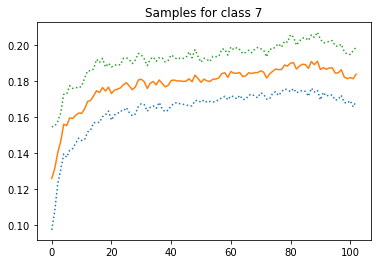

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 31%|██████████████████████▋                                                  | 31000/100000 [47:04<1:44:03, 11.05it/s]

Iter-31000; D_loss: -0.012021679431200027; G_loss: -0.17250525951385498; C_loss: 0.00859538558870554


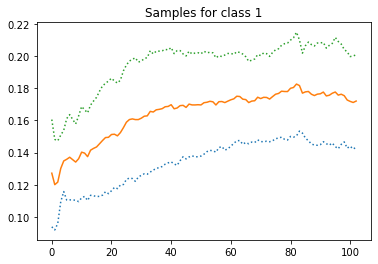

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 32%|███████████████████████▎                                                 | 32000/100000 [48:36<1:44:57, 10.80it/s]

Iter-32000; D_loss: -0.006008309777826071; G_loss: -0.16573739051818848; C_loss: 0.00998219009488821


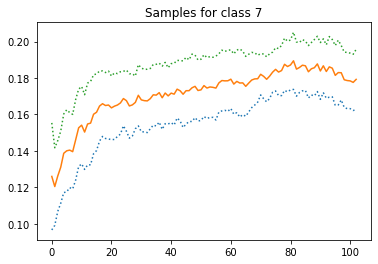

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 33%|████████████████████████                                                 | 32999/100000 [50:08<1:42:38, 10.88it/s]

Iter-33000; D_loss: -0.01363764051347971; G_loss: -0.18511337041854858; C_loss: 0.008949038572609425


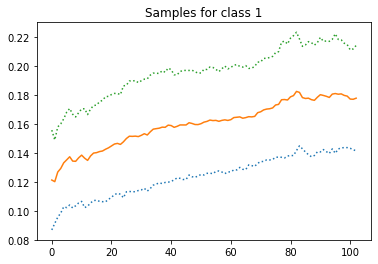

 34%|████████████████████████▊                                                | 33999/100000 [51:40<1:38:53, 11.12it/s]

Iter-34000; D_loss: -0.012689674273133278; G_loss: -0.17156913876533508; C_loss: 0.009332973510026932


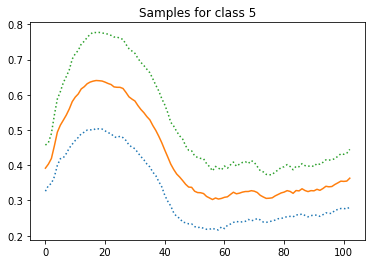

 35%|█████████████████████████▌                                               | 34999/100000 [53:13<1:39:33, 10.88it/s]

Iter-35000; D_loss: -0.010245010256767273; G_loss: -0.16323691606521606; C_loss: 0.015681667253375053


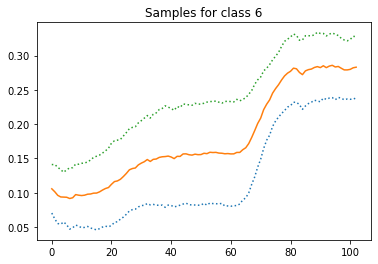

 36%|██████████████████████████▎                                              | 35999/100000 [54:45<1:38:16, 10.85it/s]

Iter-36000; D_loss: -0.010462693870067596; G_loss: -0.16596294939517975; C_loss: 0.012224476784467697


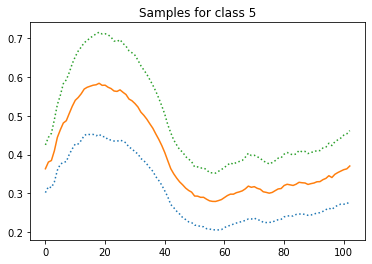

 37%|███████████████████████████                                              | 36999/100000 [56:19<1:36:38, 10.87it/s]

Iter-37000; D_loss: -0.01704627275466919; G_loss: -0.1743292212486267; C_loss: 0.014368321746587753


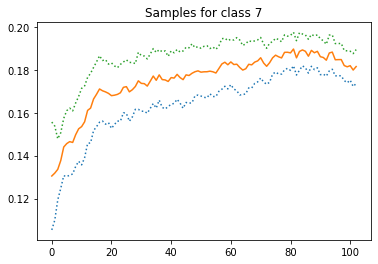

 38%|███████████████████████████▋                                             | 38000/100000 [57:51<1:35:15, 10.85it/s]

Iter-38000; D_loss: -0.009834999218583107; G_loss: -0.19376727938652039; C_loss: 0.010485216975212097


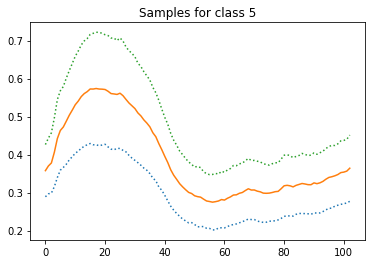

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 39%|████████████████████████████▍                                            | 39000/100000 [59:24<1:35:15, 10.67it/s]

Iter-39000; D_loss: -0.008179939351975918; G_loss: -0.16991347074508667; C_loss: 0.014209773391485214


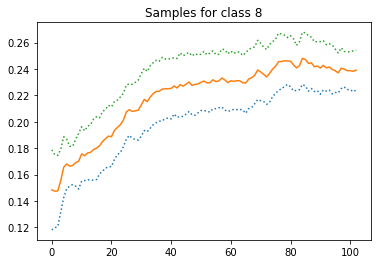

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 40%|████████████████████████████▍                                          | 39999/100000 [1:00:56<1:29:38, 11.15it/s]

Iter-40000; D_loss: -0.011070974171161652; G_loss: -0.18674302101135254; C_loss: 0.009562916122376919


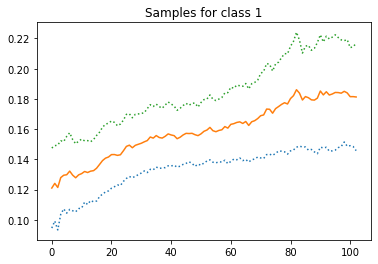

 41%|█████████████████████████████                                          | 40999/100000 [1:02:28<1:30:30, 10.86it/s]

Iter-41000; D_loss: -0.005420741159468889; G_loss: -0.19674167037010193; C_loss: 0.009732252918183804


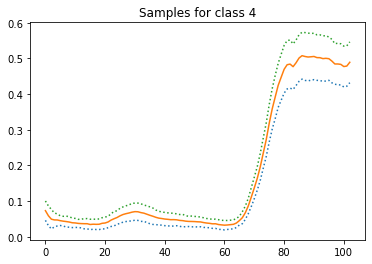

 42%|█████████████████████████████▊                                         | 41999/100000 [1:04:01<1:30:09, 10.72it/s]

Iter-42000; D_loss: -0.014840603806078434; G_loss: -0.19185715913772583; C_loss: 0.00847071222960949


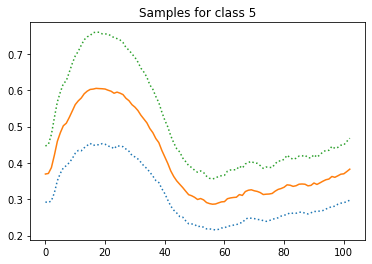

 43%|██████████████████████████████▌                                        | 42999/100000 [1:05:33<1:27:11, 10.90it/s]

Iter-43000; D_loss: -0.017471976578235626; G_loss: -0.1715129166841507; C_loss: 0.018045272678136826


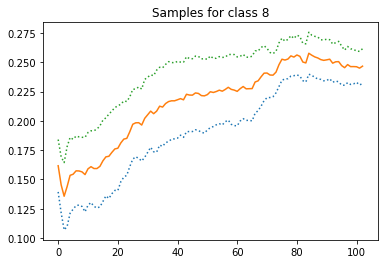

 44%|███████████████████████████████▏                                       | 43999/100000 [1:07:06<1:25:13, 10.95it/s]

Iter-44000; D_loss: -0.010771945118904114; G_loss: -0.187661811709404; C_loss: 0.012116698548197746


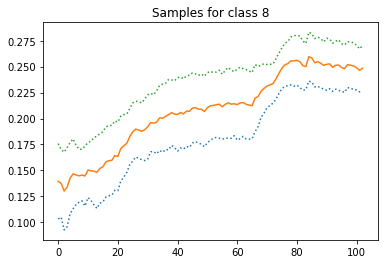

 45%|███████████████████████████████▉                                       | 45000/100000 [1:08:38<1:25:20, 10.74it/s]

Iter-45000; D_loss: -0.00929776020348072; G_loss: -0.19388112425804138; C_loss: 0.011141587048768997


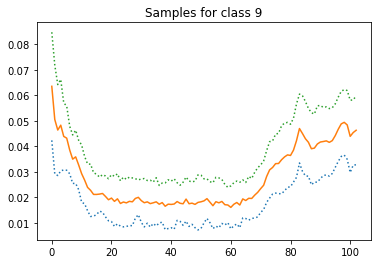

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 46%|████████████████████████████████▋                                      | 45999/100000 [1:10:10<1:21:58, 10.98it/s]

Iter-46000; D_loss: -0.009776315651834011; G_loss: -0.1876019686460495; C_loss: 0.02323186956346035


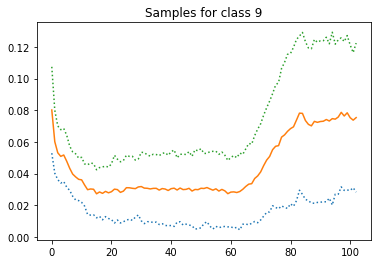

 47%|█████████████████████████████████▎                                     | 47000/100000 [1:11:43<1:20:30, 10.97it/s]

Iter-47000; D_loss: -0.011174177750945091; G_loss: -0.17938828468322754; C_loss: 0.014750865288078785


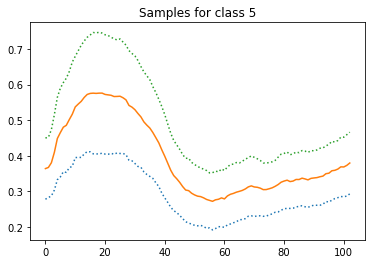

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 48%|██████████████████████████████████                                     | 47999/100000 [1:13:16<1:18:04, 11.10it/s]

Iter-48000; D_loss: -0.0035453441087156534; G_loss: -0.1908436268568039; C_loss: 0.01621541753411293


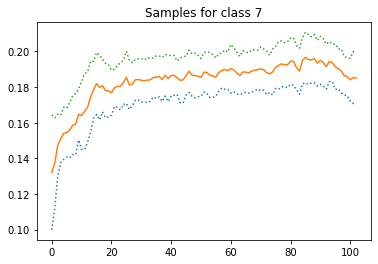

 49%|██████████████████████████████████▊                                    | 49000/100000 [1:14:48<1:16:02, 11.18it/s]

Iter-49000; D_loss: -0.010026566684246063; G_loss: -0.19880792498588562; C_loss: 0.00953805074095726


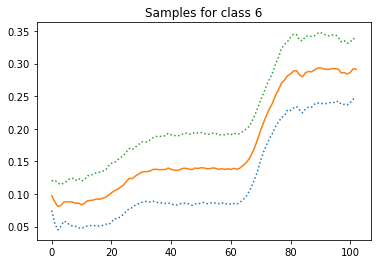

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 50%|███████████████████████████████████▍                                   | 49999/100000 [1:16:20<1:16:37, 10.88it/s]

Iter-50000; D_loss: -0.008344121277332306; G_loss: -0.19174733757972717; C_loss: 0.010546433739364147


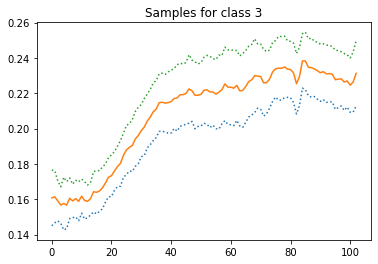

 51%|████████████████████████████████████▏                                  | 51000/100000 [1:17:50<1:11:25, 11.43it/s]

Iter-51000; D_loss: -0.009529909119009972; G_loss: -0.1882959008216858; C_loss: 0.015185934491455555


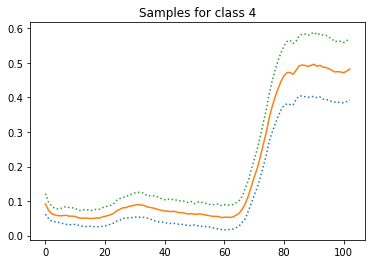

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 52%|████████████████████████████████████▉                                  | 52000/100000 [1:19:19<1:10:00, 11.43it/s]

Iter-52000; D_loss: -0.0152053227648139; G_loss: -0.1946479082107544; C_loss: 0.011185180395841599


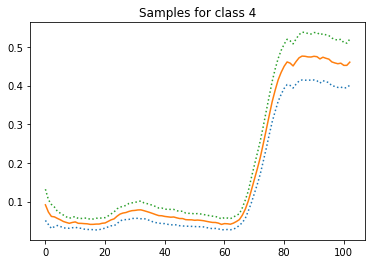

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 53%|█████████████████████████████████████▋                                 | 52999/100000 [1:20:48<1:07:55, 11.53it/s]

Iter-53000; D_loss: -0.003510720795020461; G_loss: -0.20173993706703186; C_loss: 0.010631268844008446


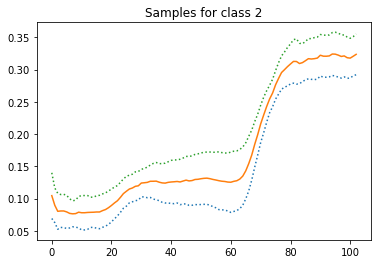

 54%|██████████████████████████████████████▎                                | 53999/100000 [1:22:16<1:07:23, 11.38it/s]

Iter-54000; D_loss: -0.00900131743401289; G_loss: -0.18490003049373627; C_loss: 0.010675395838916302


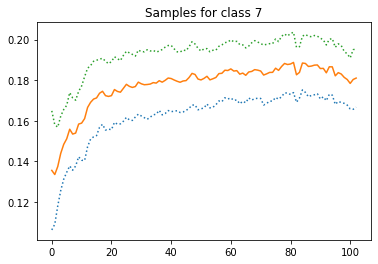

 55%|███████████████████████████████████████                                | 54999/100000 [1:23:45<1:06:04, 11.35it/s]

Iter-55000; D_loss: -0.009589317254722118; G_loss: -0.1832779347896576; C_loss: 0.013640864752233028


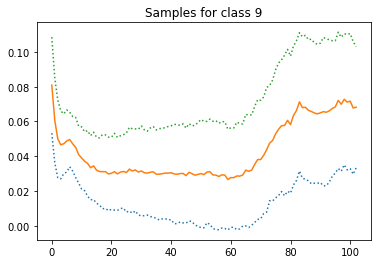

 56%|███████████████████████████████████████▊                               | 55999/100000 [1:25:14<1:03:46, 11.50it/s]

Iter-56000; D_loss: -0.008394437842071056; G_loss: -0.1923573613166809; C_loss: 0.022016875445842743


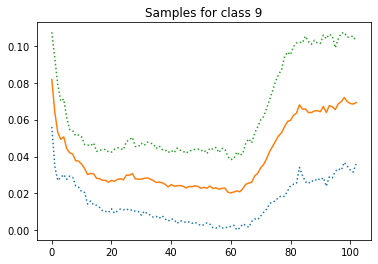

 57%|████████████████████████████████████████▍                              | 56999/100000 [1:26:43<1:02:52, 11.40it/s]

Iter-57000; D_loss: -0.008125698193907738; G_loss: -0.18409663438796997; C_loss: 0.009117784909904003


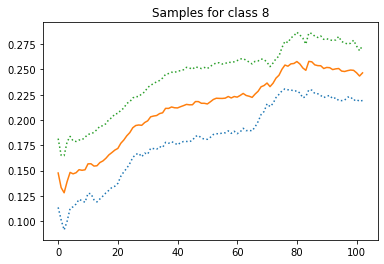

 58%|█████████████████████████████████████████▏                             | 57999/100000 [1:28:12<1:02:23, 11.22it/s]

Iter-58000; D_loss: -0.00909630861133337; G_loss: -0.18334540724754333; C_loss: 0.011805092915892601


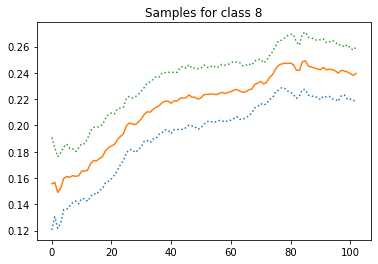

 59%|███████████████████████████████████████████                              | 58999/100000 [1:29:41<59:48, 11.42it/s]

Iter-59000; D_loss: -0.006661760155111551; G_loss: -0.1863051950931549; C_loss: 0.011054514907300472


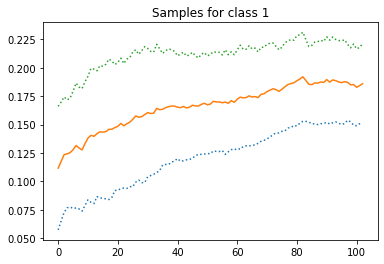

 60%|███████████████████████████████████████████▊                             | 60000/100000 [1:31:10<58:18, 11.43it/s]

Iter-60000; D_loss: -0.011950707994401455; G_loss: -0.19453522562980652; C_loss: 0.0127998236566782


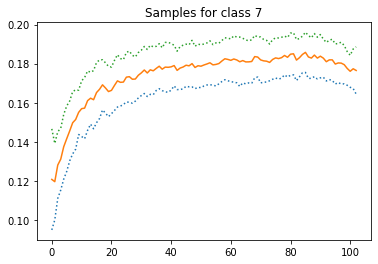

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 61%|████████████████████████████████████████████▌                            | 61000/100000 [1:32:39<56:37, 11.48it/s]

Iter-61000; D_loss: -0.00524189742282033; G_loss: -0.19852450489997864; C_loss: 0.01125932764261961


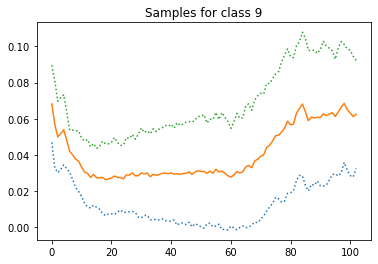

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 62%|█████████████████████████████████████████████▎                           | 61999/100000 [1:34:08<56:37, 11.18it/s]

Iter-62000; D_loss: -0.010206358507275581; G_loss: -0.18665260076522827; C_loss: 0.01080554910004139


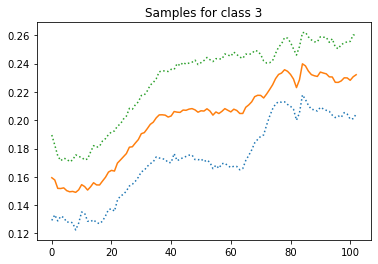

 63%|█████████████████████████████████████████████▉                           | 62999/100000 [1:35:37<55:36, 11.09it/s]

Iter-63000; D_loss: -0.013951941393315792; G_loss: -0.19175447523593903; C_loss: 0.011582204140722752


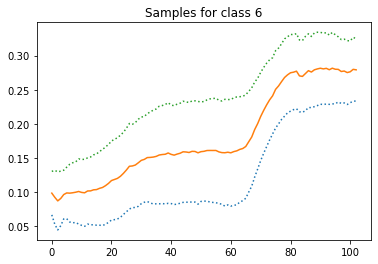

 64%|██████████████████████████████████████████████▋                          | 63999/100000 [1:37:06<52:42, 11.38it/s]

Iter-64000; D_loss: -0.01249668374657631; G_loss: -0.20048600435256958; C_loss: 0.009376497939229012


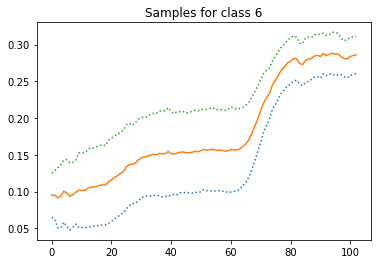

 65%|███████████████████████████████████████████████▍                         | 64999/100000 [1:38:35<51:28, 11.33it/s]

Iter-65000; D_loss: -0.009999045170843601; G_loss: -0.19082099199295044; C_loss: 0.015644408762454987


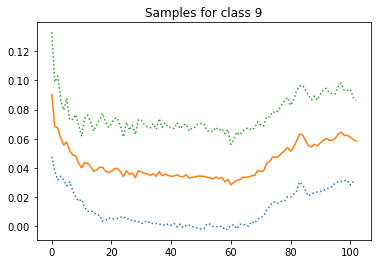

 66%|████████████████████████████████████████████████▏                        | 65999/100000 [1:40:04<49:17, 11.50it/s]

Iter-66000; D_loss: -0.012277192436158657; G_loss: -0.18706417083740234; C_loss: 0.0134581308811903


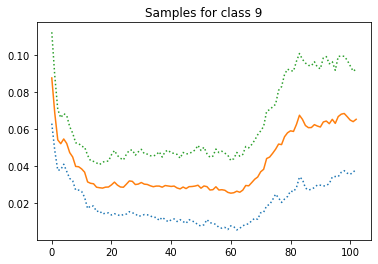

 67%|████████████████████████████████████████████████▉                        | 66999/100000 [1:41:33<51:09, 10.75it/s]

Iter-67000; D_loss: -0.014079093933105469; G_loss: -0.18723206222057343; C_loss: 0.012167089618742466


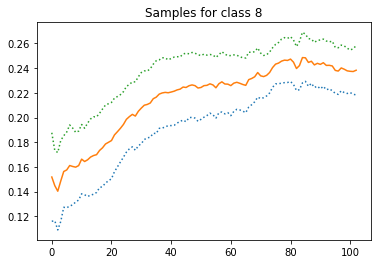

 68%|█████████████████████████████████████████████████▋                       | 68000/100000 [1:43:02<46:45, 11.41it/s]

Iter-68000; D_loss: -0.009345751255750656; G_loss: -0.19513779878616333; C_loss: 0.010537947528064251


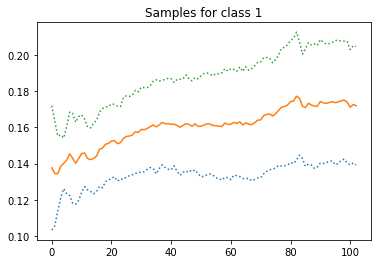

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 69%|██████████████████████████████████████████████████▎                      | 69000/100000 [1:44:31<45:11, 11.43it/s]

Iter-69000; D_loss: -0.0058057233691215515; G_loss: -0.18285143375396729; C_loss: 0.008909391239285469


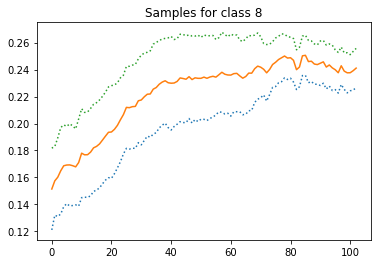

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 70%|███████████████████████████████████████████████████                      | 69999/100000 [1:46:00<43:48, 11.41it/s]

Iter-70000; D_loss: -0.008739889599382877; G_loss: -0.17939390242099762; C_loss: 0.0293907281011343


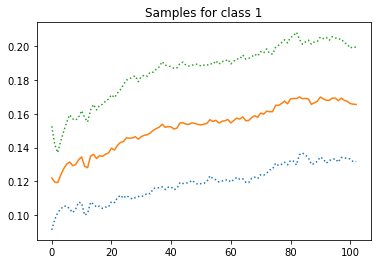

 71%|███████████████████████████████████████████████████▊                     | 70999/100000 [1:47:29<42:03, 11.49it/s]

Iter-71000; D_loss: -0.008382693864405155; G_loss: -0.18249034881591797; C_loss: 0.013874036259949207


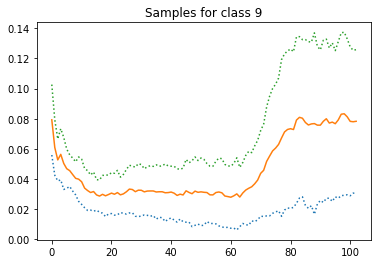

 72%|████████████████████████████████████████████████████▌                    | 71999/100000 [1:48:58<41:56, 11.13it/s]

Iter-72000; D_loss: -0.005068729631602764; G_loss: -0.2018255591392517; C_loss: 0.012543026357889175


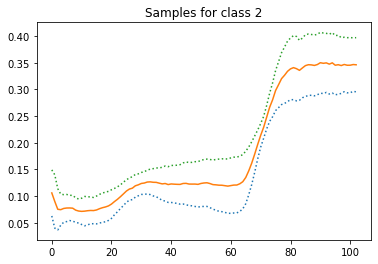

 73%|█████████████████████████████████████████████████████▎                   | 72999/100000 [1:50:27<39:19, 11.44it/s]

Iter-73000; D_loss: -0.012718111276626587; G_loss: -0.17014509439468384; C_loss: 0.055682919919490814


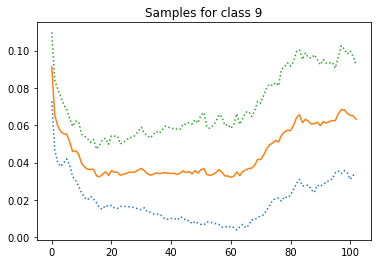

 74%|██████████████████████████████████████████████████████                   | 73999/100000 [1:51:56<37:47, 11.46it/s]

Iter-74000; D_loss: -0.013442827388644218; G_loss: -0.20628684759140015; C_loss: 0.009700807742774487


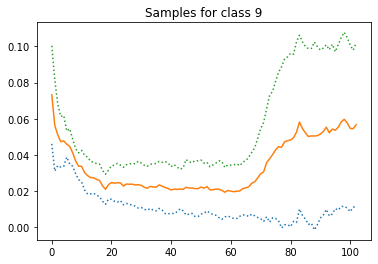

 75%|██████████████████████████████████████████████████████▋                  | 74999/100000 [1:53:25<36:40, 11.36it/s]

Iter-75000; D_loss: -0.007362602278590202; G_loss: -0.20220670104026794; C_loss: 0.0085841603577137


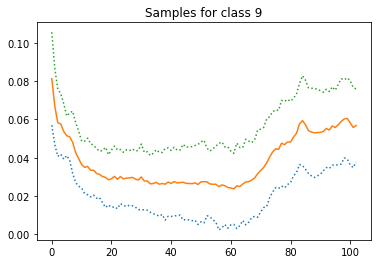

 76%|███████████████████████████████████████████████████████▍                 | 75999/100000 [1:54:54<34:56, 11.45it/s]

Iter-76000; D_loss: -0.005697605200111866; G_loss: -0.19429290294647217; C_loss: 0.02598268911242485


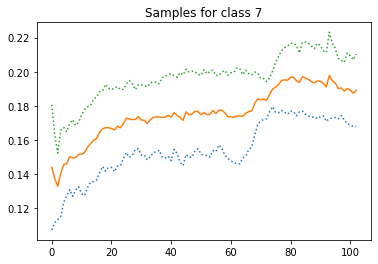

 77%|████████████████████████████████████████████████████████▏                | 76999/100000 [1:56:23<33:38, 11.39it/s]

Iter-77000; D_loss: -0.015233754180371761; G_loss: -0.1964823454618454; C_loss: 0.013678076677024364


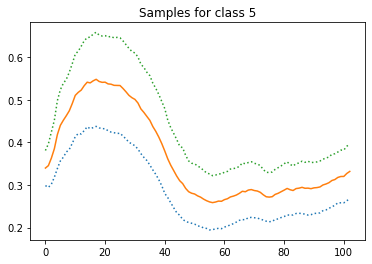

 78%|████████████████████████████████████████████████████████▉                | 77999/100000 [1:57:52<32:55, 11.14it/s]

Iter-78000; D_loss: -0.012432752177119255; G_loss: -0.1933136135339737; C_loss: 0.010970616713166237


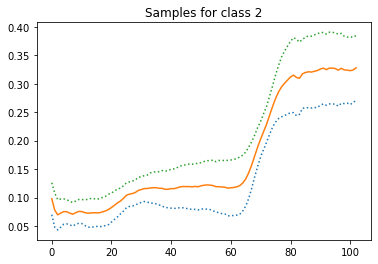

 79%|█████████████████████████████████████████████████████████▋               | 78999/100000 [1:59:21<30:44, 11.38it/s]

Iter-79000; D_loss: -0.007027696818113327; G_loss: -0.19613750278949738; C_loss: 0.01608511060476303


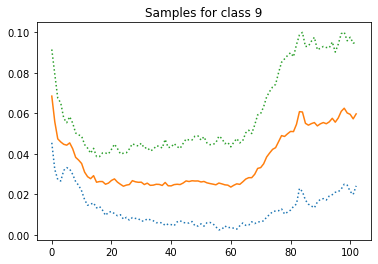

 80%|██████████████████████████████████████████████████████████▍              | 79999/100000 [2:00:50<29:06, 11.45it/s]

Iter-80000; D_loss: -0.009047320112586021; G_loss: -0.19052165746688843; C_loss: 0.012006158009171486


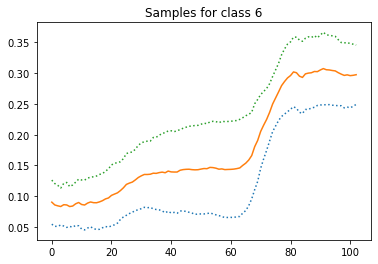

 81%|███████████████████████████████████████████████████████████▏             | 80999/100000 [2:02:19<27:42, 11.43it/s]

Iter-81000; D_loss: -0.011524995788931847; G_loss: -0.19588224589824677; C_loss: 0.010571833699941635


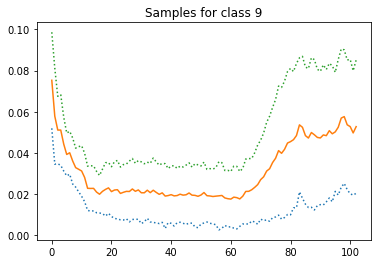

 82%|███████████████████████████████████████████████████████████▊             | 81999/100000 [2:03:48<26:13, 11.44it/s]

Iter-82000; D_loss: -0.01770079880952835; G_loss: -0.19235341250896454; C_loss: 0.011856990866363049


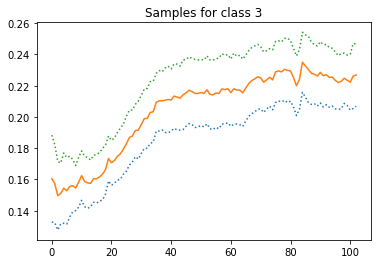

 83%|████████████████████████████████████████████████████████████▌            | 82999/100000 [2:05:17<24:58, 11.35it/s]

Iter-83000; D_loss: -0.014314226806163788; G_loss: -0.1938685029745102; C_loss: 0.010367173701524734


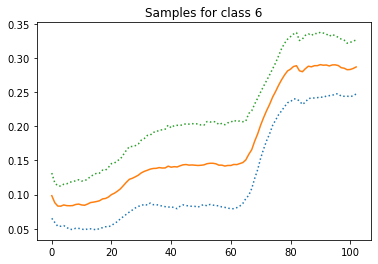

 84%|█████████████████████████████████████████████████████████████▎           | 83999/100000 [2:06:46<23:18, 11.44it/s]

Iter-84000; D_loss: -0.007207774091511965; G_loss: -0.19050443172454834; C_loss: 0.013576732017099857


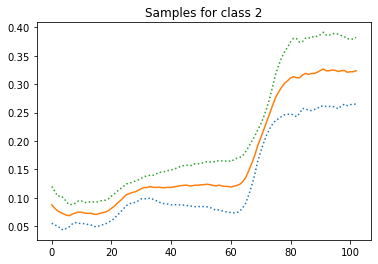

 85%|██████████████████████████████████████████████████████████████           | 84999/100000 [2:08:15<21:52, 11.43it/s]

Iter-85000; D_loss: -0.013556623831391335; G_loss: -0.1902533322572708; C_loss: 0.017234034836292267


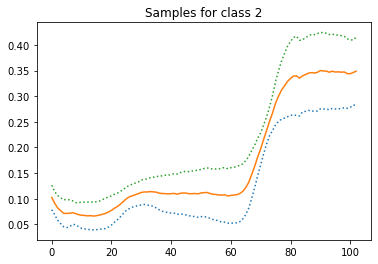

 86%|██████████████████████████████████████████████████████████████▊          | 85999/100000 [2:09:44<20:59, 11.12it/s]

Iter-86000; D_loss: -0.0036774096079170704; G_loss: -0.18853342533111572; C_loss: 0.01119375228881836


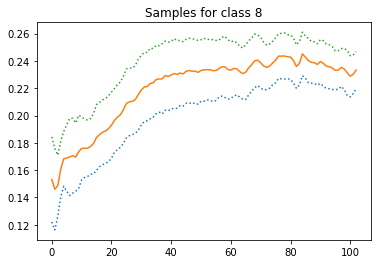

 87%|███████████████████████████████████████████████████████████████▌         | 87000/100000 [2:11:13<19:22, 11.18it/s]

Iter-87000; D_loss: -0.011157428845763206; G_loss: -0.197422057390213; C_loss: 0.007878397591412067


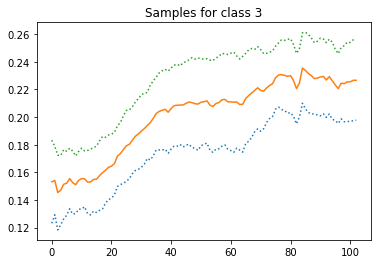

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 88%|████████████████████████████████████████████████████████████████▏        | 88000/100000 [2:12:43<17:49, 11.22it/s]

Iter-88000; D_loss: -0.009924549609422684; G_loss: -0.18635064363479614; C_loss: 0.011845678091049194


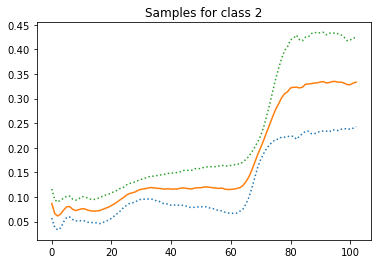

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 89%|████████████████████████████████████████████████████████████████▉        | 89000/100000 [2:14:12<16:00, 11.46it/s]

Iter-89000; D_loss: -0.019324924796819687; G_loss: -0.21281281113624573; C_loss: 0.00537237711250782


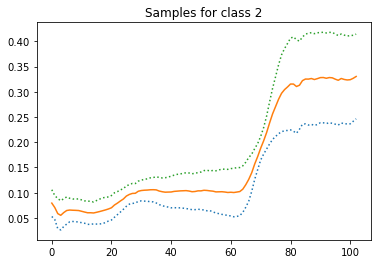

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 90%|█████████████████████████████████████████████████████████████████▋       | 89999/100000 [2:15:41<14:32, 11.47it/s]

Iter-90000; D_loss: -0.006321350112557411; G_loss: -0.19591295719146729; C_loss: 0.010552733205258846


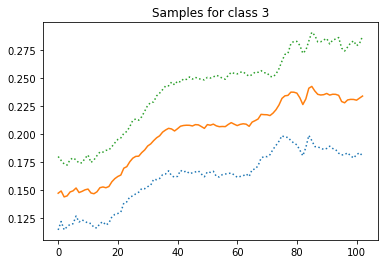

 91%|██████████████████████████████████████████████████████████████████▍      | 90999/100000 [2:17:10<13:09, 11.40it/s]

Iter-91000; D_loss: -0.009279360994696617; G_loss: -0.20118632912635803; C_loss: 0.016043735668063164


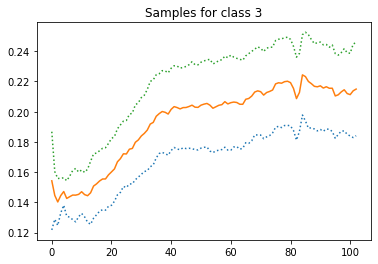

 92%|███████████████████████████████████████████████████████████████████▏     | 91999/100000 [2:18:39<11:43, 11.37it/s]

Iter-92000; D_loss: -0.01181840617209673; G_loss: -0.19761429727077484; C_loss: 0.00943605788052082


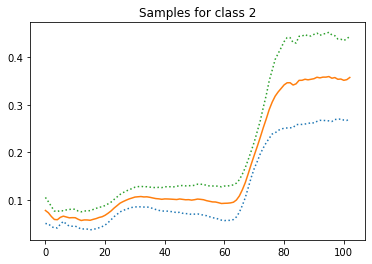

 93%|███████████████████████████████████████████████████████████████████▉     | 92999/100000 [2:20:08<10:13, 11.41it/s]

Iter-93000; D_loss: -0.01125154085457325; G_loss: -0.19613215327262878; C_loss: 0.009003193117678165


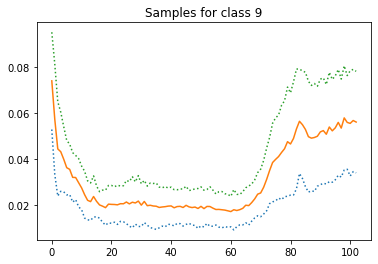

 94%|████████████████████████████████████████████████████████████████████▌    | 93999/100000 [2:21:36<08:40, 11.53it/s]

Iter-94000; D_loss: -0.01061050035059452; G_loss: -0.19710779190063477; C_loss: 0.007528405636548996


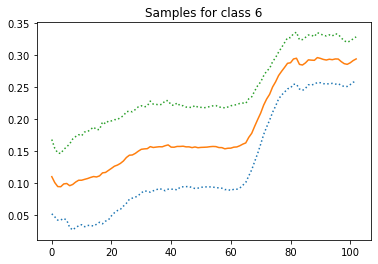

 95%|█████████████████████████████████████████████████████████████████████▎   | 94999/100000 [2:23:05<07:17, 11.42it/s]

Iter-95000; D_loss: -0.010768169537186623; G_loss: -0.19581782817840576; C_loss: 0.007835540920495987


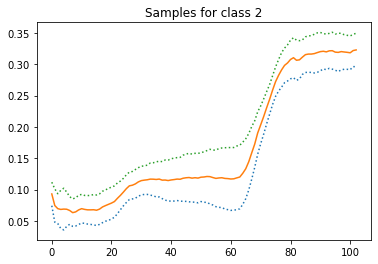

 96%|██████████████████████████████████████████████████████████████████████   | 95999/100000 [2:24:35<05:59, 11.13it/s]

Iter-96000; D_loss: -0.010774390771985054; G_loss: -0.1911264955997467; C_loss: 0.008603649213910103


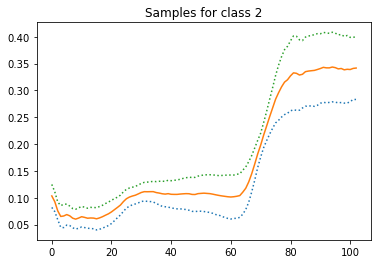

 97%|██████████████████████████████████████████████████████████████████████▊  | 96999/100000 [2:26:04<04:21, 11.46it/s]

Iter-97000; D_loss: -0.012422380968928337; G_loss: -0.19690591096878052; C_loss: 0.012563200667500496


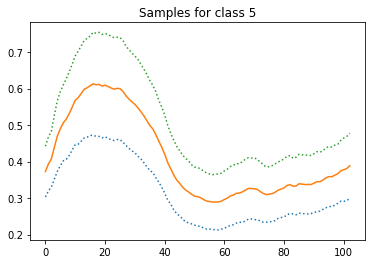

 98%|███████████████████████████████████████████████████████████████████████▌ | 97999/100000 [2:27:33<02:59, 11.14it/s]

Iter-98000; D_loss: -0.012768847867846489; G_loss: -0.19846372306346893; C_loss: 0.01009057741612196


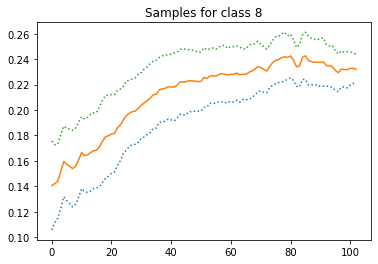

 99%|████████████████████████████████████████████████████████████████████████▎| 99000/100000 [2:29:02<01:28, 11.27it/s]

Iter-99000; D_loss: -0.004802456591278315; G_loss: -0.19013376533985138; C_loss: 0.012044288218021393


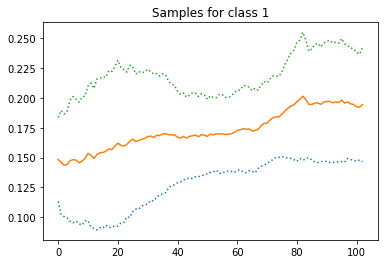

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [2:30:31<00:00, 11.07it/s]


In [14]:
# Get networks
G = Generator().cuda()
D = Discriminator().cuda()
C = Classifier().cuda()

# Use RMSProp optimizer
G_solver = optim.RMSprop(G.parameters(), lr=lr)
D_solver = optim.RMSprop(D.parameters(), lr=lr)
C_solver = optim.RMSprop(C.parameters(), lr=lr)

for it in tqdm(range(100000)):
    ###########################
    # (1) Update C and D      #
    ###########################
    for p in D.parameters():  # reset requires_grad
        p.requires_grad = True  # they are set to False below in netG update
    for p in C.parameters():
        p.requires_grad = True
    
    # D is trained d_step times for each iteration
    
    for _, (X, y), (X_, y_) in zip(range(d_step), data_loader, data_loader):
        D.zero_grad()

        # Sample random noise
        z = torch.randn(y.size(0), z_dim).squeeze()
        X, y = X.float(), y.float()
        X_, y_ = X_.float(), y_.float()
        # Mixup
        lam = np.random.beta(mixup_alpha, mixup_alpha)
        X = lam*X + (1. - lam)*X_
        X, y, z = X.cuda(), y.cuda(), z.cuda()
        y_ = y_.cuda()
        
        # Get discriminator prediction on real samples
        D_real = D(X).mean()
        # Get discriminator prediction on fake samples
        fake_samples = G(z, y)
        D_fake = D(fake_samples).mean()
        # Compute gradient penalty
        gradient_penalty = calc_gradient_penalty(D, X.data, fake_samples.data)
        # Compute loss and backpropagate
        D_loss = D_fake - D_real + gradient_penalty
        flip = np.random.random() < flip_percentage
        if flip: 
            # Flip real and fake
            gradient_penalty = calc_gradient_penalty(D, fake_samples.data, X.data)
            D_loss = D_real - D_fake + gradient_penalty
        D_loss.backward()
        D_solver.step()
    
        ######################
        #  Update C network  #
        ######################
        C.zero_grad()
        # Get class values
        _, classes = torch.max(y, dim=1)
        _, classes_ = torch.max(y_, dim=1)
        # Get predictions from C
        if flip:
            fake_samples = G(z, y)
            pred = C(fake_samples)
            # Compute loss and backpropagate
            C_loss = F.cross_entropy(pred, classes, weight=class_weights)
        else:
            pred = F.log_softmax(C(X))
            C_loss = lam * F.nll_loss(pred, classes) + (1. - lam) * F.nll_loss(pred, classes_)
        C_loss.backward()
        C_solver.step()


    ############################
    # (2) Update G network
    ###########################
    for p in D.parameters():
        p.requires_grad = False  # to avoid computation
    for p in C.parameters():
        p.requires_grad = False
    reset_grad(C, G, D)

    # Sample random noise
    z = torch.randn(y.size(0), z_dim).squeeze()
    z = z.cuda()
    # Generate fake samples
    G_sample = G(z, y)
    D_fake = D(G_sample)
    pred = C(G_sample)
    C_loss = F.cross_entropy(pred, classes, weight=class_weights)
    # Fool the discriminator (WGAN)
    G_loss = -torch.mean(D_fake)
    # Include the auxialiary classifier loss (AC-GAN)
    loss = G_loss + c_weight * C_loss
    # Backpropagate
    loss.backward()
    G_solver.step()

    # Print and plot every now and then
    if it % 1000 == 0:
        with torch.no_grad():
            print('Iter-{}; D_loss: {}; G_loss: {}; C_loss: {}'.format(it,
                                                           D_loss.data.cpu().numpy(), G_loss.data.cpu().numpy(),
                                                           C_loss.data.cpu().numpy()))
            z = torch.randn(mb_size, z_dim).squeeze().cuda()
            c = np.zeros(shape=[mb_size, c_dim], dtype='float32')
            idx = np.random.randint(1, data_loader.dataset.n_classes)
            c[:, idx] = 1.
            c = torch.from_numpy(c).squeeze().cuda()
            samples = G(z, c).data.cpu().numpy()[:16]
            pred = G(z, c)
            plot_mean_std(samples)
            plt.title("Samples for class {}".format(idx))
            plt.show()

## Data generation

Now that the generator has been trained, we can generate some fake spectra and see how they fare visually against the real ones.

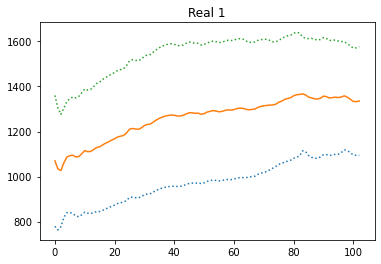

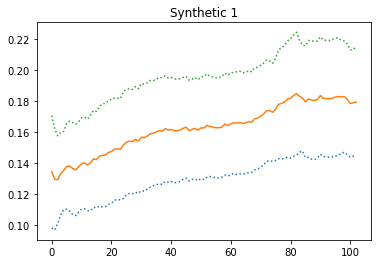

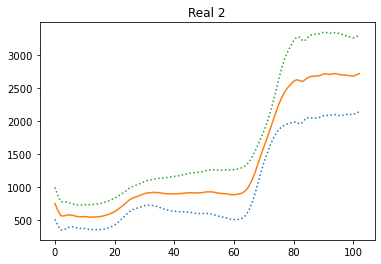

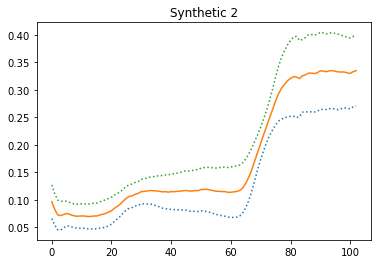

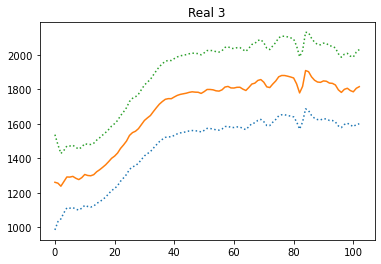

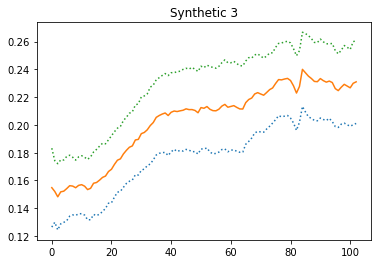

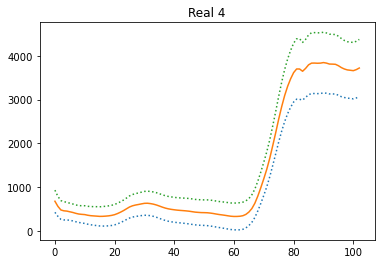

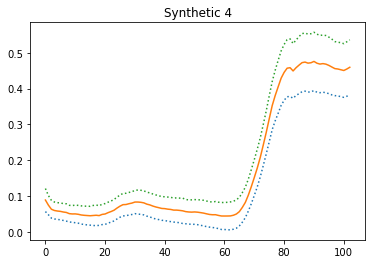

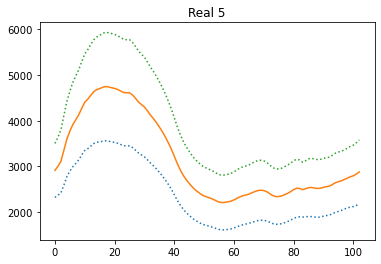

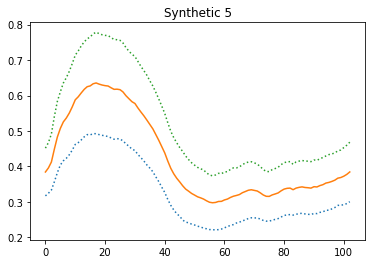

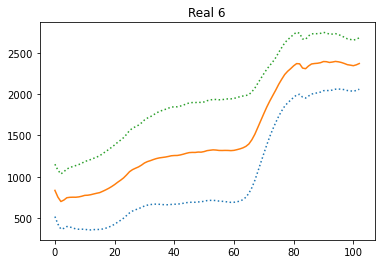

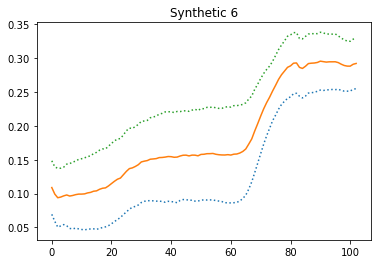

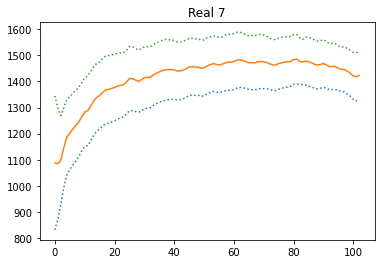

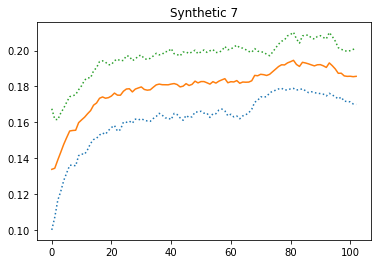

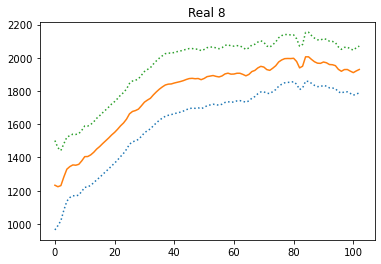

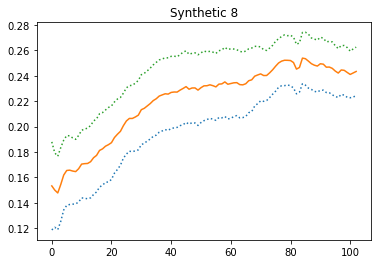

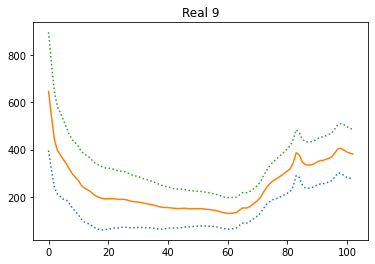

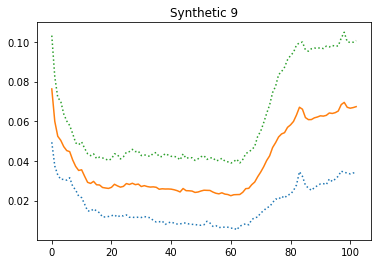

In [15]:
for c in np.unique(gt):
    # 0 is the "undefined" class
    if c == 0:
        continue
    
    # Get the mean spectrum +- std for this class
    spectras = img[gt == c, :]
    plot_mean_std(spectras)
    plt.title("Real {}".format(c))
    plt.show()
    
    # Get as many fake spectras as real ones
    synthetic_spectras = []
    with torch.no_grad():
        while len(synthetic_spectras) < len(spectras):
            z = torch.randn(mb_size, z_dim).cuda()
            y = torch.from_numpy(np.eye(data_loader.dataset.n_classes)[c]).float()
            y = y.unsqueeze(0).repeat(mb_size, 1).cuda()
            G_sample = G(z, y)
            _, classes = torch.max(y, 1)
            _, pred = torch.max(C(G_sample), 1)
            synthetic_spectras += list(G_sample.cpu().data.numpy())
    plt.show()
    plot_mean_std(synthetic_spectras)
    plt.title("Synthetic {}".format(c))
    plt.show()

In [16]:
torch.cuda.empty_cache()


### SVM on fake data

We now generate some fake data (in the same quantities as the real data) and apply the trained SVM on it.

In [77]:
def gan_create_fake_dataset(labels):
    with torch.no_grad():
        spectras = []
        for l in np.array_split(labels, len(labels) // mb_size):
            
            z = torch.randn(len(l), z_dim).cuda()
            y = np.zeros((len(l), data_loader.dataset.n_classes))
            for i, label in enumerate(l):
                y[i] = np.eye(data_loader.dataset.n_classes)[label]
            y = torch.from_numpy(y).float()
            eps = torch.randn(y.size())/10
            #y += eps
            y = y.cuda()
            G_sample = G(z, y)
            spectras += list(G_sample.cpu().data.numpy())
        return np.array(spectras), np.array(labels)

In [55]:
# (unique, counts) = np.unique(gt, return_counts=True)
# frequencies = np.asarray((unique, counts)).T
# print(frequencies)

In [125]:
from PIL import Image
gt_zip = zip(*np.nonzero(gt))
_gt = np.array([gt[x,y] for x,y in gt_zip])
# _axis_x = np.array([x for x,y in gt_zip])
# _axis_y = np.array([y for x,y in gt_zip])
out_pixels, out_gt_img = gan_create_fake_dataset(_gt)
input_width = np.shape(img)[0]
input_height = np.shape(img)[1]

# test_img = np.reshape(out_img,(input_width,-1,X_dim) )
# print(np.shape(test_img))
print(np.shape(_gt))
print(np.shape(img))
print(out_pixels.shape)
print(_gt)

(42776,)
(610, 340, 103)
(42776, 103)
[1 1 1 ... 2 2 2]


In [126]:
out_img = np.array(img, copy=True)

# print(out_img.shape)
# print(_gt)
out_indexes = np.array([(x, y) for x,y in zip(*np.nonzero(gt))]).astype(np.uint8)
print(out_indexes.shape)
np.put(out_img,out_indexes,out_pixels[i])            

(42776, 2)


In [121]:
print(np.shape(out_img))
print(np.shape(out_gt_img))

(610, 340, 103)
(42776,)


In [59]:
# test_shape = io.imread('C:\\Users\\golde\\Documents\\GitHub\\AeroRIT\\Aerial Data\\Collection\\image_hsi_radiance.tif')
# print(np.shape(test_shape))

In [72]:
rotated_back = np.transpose(out_img, [2,0,1])
imsave('./output_images/test.tif', rotated_back)
print(rotated_back.shape)

(103, 610, 340)


In [61]:
# _counts = np.asarray(np.unique(rotated_back,return_counts=True))
# print(len(_counts[0]),_counts.T)
# _counts = np.asarray(np.unique(out_pixels,return_counts=True))
# print(len(_counts[0]),_counts.T)
# _counts = np.asarray(np.unique(img,return_counts=True))
# print(len(_counts[0]),_counts.T)

(610, 340, 103)


ValueError: Third dimension must be 3 or 4

In [63]:
# pavia_img = loadmat('./PaviaU.mat')['paviaU']
# print(np.transpose(rotated_back, [2,1,0])[0][0])
# print(img[0][0])
# print(pavia_img[0][0])

In [64]:
# matplotlib.image.imsave("./output_images/test_rgb.png", np.transpose(rotated_back, [2,1,0])[:,:,(43,24,4)])

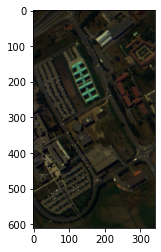

In [130]:
import scipy.io as sio
from tifffile import imsave
import matplotlib

# 
# imsave('./output_images/test.tif', rotated_back)



# matplotlib.image.imsave("./output_images/out_img.tif", out_img)
# im = Image.new('L', (input_width, input_height))
# im.putdata(out_img.flatten().tolist())
# im.save("filename.tiff", format="TIFF", save_all=True)
# out_rgb = out_img[:,:,(54,41,12)]
out_rgb = out_img[:,:,(55,41,12)]
out_rgb = (255 * (out_rgb.astype(np.float32) - out_rgb.min())/(out_rgb.max() - out_rgb.min())).astype(np.uint8)
plt.imshow(out_rgb)
matplotlib.image.imsave("./output_images/out_rgb.png", out_rgb)


savedict = {
    'paviaU_out' : out_img,
}
sio.savemat('./output_images/out_img_pavia.mat', savedict)

#out_gt_img = Image.fromarray(out_gt_img)
#out_img.save("./output_images/out_img.tif")
#out_gt_img.save("./output_images/out_gt_img.png")